# **Playground Series - Season 4, Episode 12**

![Kaggle](https://img.shields.io/badge/Kaggle-Competition-blue.svg)  
A project to solve the Kaggle competition [Playground Series - Season 4, Episode 12](https://www.kaggle.com/competitions/playground-series-s4e12/overview), where the objective is to predict whether a customer will take a product (`ProdTaken`) based on demographic and travel-related features.

---

## **Table of Contents**
- [Dataset](#dataset)
- [Objective](#objective)
- [Project Structure](#project-structure)
- [Installation](#installation)
- [Approach](#approach)
- [Results](#results)
- [Contributing](#contributing)
- [License](#license)

---

## **Dataset**
The dataset for this competition can be found [here](https://www.kaggle.com/competitions/playground-series-s4e12/data).

### **Data Details**
The dataset contains the following:
- **Training Data (`train.csv`)**: Used for training the machine learning model.
- **Test Data (`test.csv`)**: Used for generating predictions for submission.
- **Sample Submission File (`sample_submission.csv`)**: Format for submitting predictions.

**Target Variable**:  
- `ProdTaken` (1 = Product Taken, 0 = Product Not Taken)

---

## **Objective**
The goal is to build a classification model to predict the likelihood of a customer taking the product (`ProdTaken`) based on various features provided in the dataset.

---

## **Project Structure**
The repository is structured as follows:

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [3]:
#@title Import the kaggle dataset
from google.colab import files
files.upload()
# Create a directory for Kaggle and move the API key there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Set permissions for the Kaggle API key
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c playground-series-s4e12
!unzip -q playground-series-s4e12.zip

Saving kaggle.json to kaggle (1).json
 94% 71.0M/75.5M [00:00<00:00, 110MB/s]
100% 75.5M/75.5M [00:00<00:00, 111MB/s]


In [4]:
#@title load the datatset
# Load the training and test datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Display the first few rows of the train dataset
print(train.head())

   id   Age  Gender  Annual Income Marital Status  Number of Dependents  \
0   0  19.0  Female        10049.0        Married                   1.0   
1   1  39.0  Female        31678.0       Divorced                   3.0   
2   2  23.0    Male        25602.0       Divorced                   3.0   
3   3  21.0    Male       141855.0        Married                   2.0   
4   4  21.0    Male        39651.0         Single                   1.0   

  Education Level     Occupation  Health Score  Location  ... Previous Claims  \
0      Bachelor's  Self-Employed     22.598761     Urban  ...             2.0   
1        Master's            NaN     15.569731     Rural  ...             1.0   
2     High School  Self-Employed     47.177549  Suburban  ...             1.0   
3      Bachelor's            NaN     10.938144     Rural  ...             1.0   
4      Bachelor's  Self-Employed     20.376094     Rural  ...             0.0   

   Vehicle Age  Credit Score  Insurance Duration           Pol

In [5]:
#@title exploring the data set
# Check for missing values
print("Missing values in training data:")
print(train.isnull().sum())

# Check the data types
print("\nData types in the training data:")
print(train.dtypes)

# Display target variable distribution
print("\nTarget variable distribution:")
print(train['Premium Amount'].value_counts())

Missing values in training data:
id                           0
Age                      18705
Gender                       0
Annual Income            44949
Marital Status           18529
Number of Dependents    109672
Education Level              0
Occupation              358075
Health Score             74076
Location                     0
Policy Type                  0
Previous Claims         364029
Vehicle Age                  6
Credit Score            137882
Insurance Duration           1
Policy Start Date            0
Customer Feedback        77824
Smoking Status               0
Exercise Frequency           0
Property Type                0
Premium Amount               0
dtype: int64

Data types in the training data:
id                        int64
Age                     float64
Gender                   object
Annual Income           float64
Marital Status           object
Number of Dependents    float64
Education Level          object
Occupation               object
Health Score 

In [7]:
#@title handling missing values
# Fill missing values for numerical columns with the median
num_columns_train = train.select_dtypes(include=['float64', 'int64']).columns
train[num_columns_train] = train[num_columns_train].fillna(train[num_columns_train].median())

num_columns_test = test.select_dtypes(include=['float64', 'int64']).columns
test[num_columns_test] = test[num_columns_test].fillna(test[num_columns_test].median())


# Fill missing values for categorical columns with the mode
cat_columns_train = train.select_dtypes(include=['object']).columns
train[cat_columns_train] = train[cat_columns_train].fillna(train[cat_columns_train].mode().iloc[0])

cat_columns_test = test.select_dtypes(include=['object']).columns
test[cat_columns_test] = test[cat_columns_test].fillna(test[cat_columns_test].mode().iloc[0])

In [11]:
#@title encode categorical features
# Encode categorical columns using Label Encoding
label_encoder = LabelEncoder()

for col in cat_columns_test:
    # Convert all values to strings before fitting and transforming
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)

    # Fit on the combined unique values from both train and test
    all_values = pd.concat([train[col], test[col]]).unique()
    label_encoder.fit(all_values)

    train[col] = label_encoder.transform(train[col])
    test[col] = label_encoder.transform(test[col])

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Function to calculate VIF
def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data["feature"] = data.columns
    vif_data["VIF"] = [
        variance_inflation_factor(data.values, i) for i in range(data.shape[1])
    ]
    return vif_data

# Select numerical features only
train_numerical = train.select_dtypes(include=['float64', 'int64'])

# Calculate initial VIF
vif = calculate_vif(train_numerical)
print("Initial VIF:")
print(vif)

# Iteratively remove features with high VIF
threshold = 5  # Set your VIF threshold
while vif['VIF'].max() > threshold:
    # Find the feature with the highest VIF
    high_vif_feature = vif.loc[vif['VIF'].idxmax(), 'feature']
    print(f"Removing feature: {high_vif_feature} with VIF: {vif['VIF'].max()}")

    # Drop the feature with the highest VIF
    train_numerical = train_numerical.drop(columns=[high_vif_feature])

    # Recalculate VIF
    vif = calculate_vif(train_numerical)

print("Final features with acceptable VIF:")
print(vif)

# Update the original dataset with reduced features
train = train[train_numerical.columns]


Initial VIF:
                 feature        VIF
0                     id   3.817374
1                    Age   8.912622
2                 Gender   1.978742
3          Annual Income   2.027273
4         Marital Status   2.485730
5   Number of Dependents   3.104630
6        Education Level   2.722832
7             Occupation   1.702549
8           Health Score   5.316788
9               Location   2.438750
10           Policy Type   2.448497
11       Previous Claims   2.465212
12           Vehicle Age   3.588943
13          Credit Score  13.562283
14    Insurance Duration   4.476885
15     Policy Start Date   2.798151
16     Customer Feedback   2.218417
17        Smoking Status   1.975954
18    Exercise Frequency   2.754041
19         Property Type   2.442240
20        Premium Amount   2.559260
Removing feature: Credit Score with VIF: 13.562282548213062
Removing feature: Age with VIF: 8.270398854278916
Final features with acceptable VIF:
                 feature       VIF
0             

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 19 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Gender                1200000 non-null  int64  
 2   Annual Income         1200000 non-null  float64
 3   Marital Status        1200000 non-null  int64  
 4   Number of Dependents  1200000 non-null  float64
 5   Education Level       1200000 non-null  int64  
 6   Occupation            1200000 non-null  int64  
 7   Health Score          1200000 non-null  float64
 8   Location              1200000 non-null  int64  
 9   Policy Type           1200000 non-null  int64  
 10  Previous Claims       1200000 non-null  float64
 11  Vehicle Age           1200000 non-null  float64
 12  Insurance Duration    1200000 non-null  float64
 13  Policy Start Date     1200000 non-null  int64  
 14  Customer Feedback     1200000 non-

In [16]:
#@title scale the train data
scaler = StandardScaler()

# Identify numerical columns
num_columns = train.select_dtypes(include=['float64', 'int64']).columns
num_columns = num_columns.drop('Premium Amount')  # Exclude target column

# Scale numerical features
train[num_columns] = scaler.fit_transform(train[num_columns])
test[num_columns] = scaler.transform(test[num_columns])

<ipython-input-16-eee74148a5a8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[num_columns] = scaler.fit_transform(train[num_columns])


In [18]:
#@title split the training data between training and validation
X = train.drop('Premium Amount', axis=1)
y = train['Premium Amount']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of training data:", X_train.shape)
print("Shape of validation data:", X_val.shape)

Shape of training data: (960000, 18)
Shape of validation data: (240000, 18)


In [21]:
#@title linear regression model
# Create a Linear Regression model
from sklearn.linear_model import LinearRegression

model1 = LinearRegression()

# Train model
model1.fit(X_train , y_train)
# Test model
y_pred = model1.predict(X_val)
# Evaluate the model
from sklearn.metrics import *
print("R2 score of model with OLS by default present :",r2_score(y_val , y_pred) )

mse= mean_squared_error(y_val, y_pred)
print("MSE score of the model with lin reg by default present :", mse)

R2 score of model with OLS by default present : 0.0017015241408736559
MSE score of the model with OLS by default present : 746014.0616594491


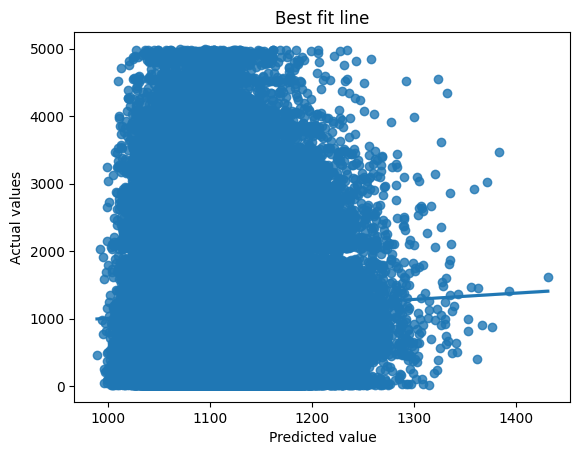

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.regplot(x=y_pred , y =y_val)
plt.title("Best fit line")
plt.xlabel("Predicted value")
plt.ylabel("Actual values")
plt.show()

In [25]:
#@title Perform the data analysis using OLS
import pandas as pd
import numpy as np
from statsmodels.api import OLS, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Function to calculate VIF
def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data["feature"] = data.columns
    vif_data["VIF"] = [
        variance_inflation_factor(data.values, i) for i in range(data.shape[1])
    ]
    return vif_data

# Step 1: Prepare the data
# read the train and test data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
# Check for missing values
print("Missing values in training data:")
print(train.isnull().sum())

# Check the data types
print("\nData types in the training data:")
print(train.dtypes)

# Display target variable distribution
print("\nTarget variable distribution:")
print(train['Premium Amount'].value_counts())
####
# Fill missing values for numerical columns with the median
num_columns_train = train.select_dtypes(include=['float64', 'int64']).columns
train[num_columns_train] = train[num_columns_train].fillna(train[num_columns_train].median())
num_columns_test = test.select_dtypes(include=['float64', 'int64']).columns
test[num_columns_test] = test[num_columns_test].fillna(test[num_columns_test].median())
# Fill missing values for categorical columns with the mode
cat_columns_train = train.select_dtypes(include=['object']).columns
train[cat_columns_train] = train[cat_columns_train].fillna(train[cat_columns_train].mode().iloc[0])

cat_columns_test = test.select_dtypes(include=['object']).columns
test[cat_columns_test] = test[cat_columns_test].fillna(test[cat_columns_test].mode().iloc[0])

############
# Encode categorical columns using Label Encoding
label_encoder = LabelEncoder()

for col in cat_columns_test:
    # Convert all values to strings before fitting and transforming
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)

    # Fit on the combined unique values from both train and test
    all_values = pd.concat([train[col], test[col]]).unique()
    label_encoder.fit(all_values)

    train[col] = label_encoder.transform(train[col])
    test[col] = label_encoder.transform(test[col])


# make `X` as feature matrix and `y` as target variable
X = train.drop('Premium Amount', axis=1)
y = train['Premium Amount']

# Select numerical features only for VIF calculation
X_numerical = X.select_dtypes(include=['float64', 'int64'])

# Step 2: Iteratively Remove Features with High VIF
threshold = 5  # Set a threshold for VIF
while True:
    vif = calculate_vif(X_numerical)
    max_vif = vif['VIF'].max()
    if max_vif > threshold:
        # Remove the feature with the highest VIF
        high_vif_feature = vif.loc[vif['VIF'].idxmax(), 'feature']
        print(f"Removing feature '{high_vif_feature}' with VIF: {max_vif}")
        X_numerical = X_numerical.drop(columns=[high_vif_feature])
    else:
        break

# Final VIF result
print("\nFinal features with acceptable VIF:")
print(calculate_vif(X_numerical))

# Step 3: Fit OLS Model with Reduced Features
# Add a constant term for OLS regression
X_numerical_with_const = add_constant(X_numerical)

# Fit the OLS model
ols_model = OLS(y, X_numerical_with_const).fit()

# Step 4: Interpret the OLS Model
print("\nOLS Model Summary:")
print(ols_model.summary())

Missing values in training data:
id                           0
Age                      18705
Gender                       0
Annual Income            44949
Marital Status           18529
Number of Dependents    109672
Education Level              0
Occupation              358075
Health Score             74076
Location                     0
Policy Type                  0
Previous Claims         364029
Vehicle Age                  6
Credit Score            137882
Insurance Duration           1
Policy Start Date            0
Customer Feedback        77824
Smoking Status               0
Exercise Frequency           0
Property Type                0
Premium Amount               0
dtype: int64

Data types in the training data:
id                        int64
Age                     float64
Gender                   object
Annual Income           float64
Marital Status           object
Number of Dependents    float64
Education Level          object
Occupation               object
Health Score 